# Question 2

In [1]:
#imports
library(readr)
suppressMessages(library(tigerstats))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library("DESeq2"))
suppressMessages(library("vsn"))
suppressMessages(library("pheatmap"))
suppressMessages(library("RColorBrewer"))
suppressMessages(library(repr))

In [43]:
#load data
cd <- read_tsv("clinical-data.tsv") 
mc <- read_tsv("morphological-counts.tsv")

Rows: 136 Columns: 12
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (5): SMPLID, SMPTHNTS, COHORT, SUBJID, IMGURL
dbl (7): SEX, AGE, HGHT, WGHT, BMI, TRISCHD, DTHHRDY

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136 Columns: 65
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr  (1): SMPLID
dbl (64): Mophological.cluster.0, Mophological.cluster.1, Mophological.clust...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
cd

SMPLID,SEX,AGE,HGHT,WGHT,BMI,SMPTHNTS,COHORT,TRISCHD,DTHHRDY,SUBJID,IMGURL
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
GTEX-11EM3-0126,2,21,59,110.00,22.21,"2 pieces, small attachment of fibrofatty tissue",Organ Donor (OPO),18,0,GTEX.11EM3,https://brd.nci.nih.gov/brd/specimen/GTEX-11EM3-0126
GTEX-11EQ9-0626,1,33,68,166.00,25.24,"2 pieces, focal lyphocytic thyroiditis, delineated, adherent fibrous/adipose tissue ~1mm",Organ Donor (OPO),15,2,GTEX.11EQ9,https://brd.nci.nih.gov/brd/specimen/GTEX-11EQ9-0626
GTEX-11LCK-0526,1,38,71,239.00,33.33,"2 pieces, regressive areas, adherent fat/fibrous tags, delineated",Organ Donor (OPO),166,0,GTEX.11LCK,https://brd.nci.nih.gov/brd/specimen/GTEX-11LCK-0526
GTEX-11NSD-0126,1,27,68,184.60,28.07,"2 pieces, ~2mm colloid cyst, featurs of goiter, regressive changes",Organ Donor (OPO),36,0,GTEX.11NSD,https://brd.nci.nih.gov/brd/specimen/GTEX-11NSD-0126
GTEX-11O72-2326,1,48,72,220.00,29.83,2 pieces,Postmortem,919,2,GTEX.11O72,https://brd.nci.nih.gov/brd/specimen/GTEX-11O72-2326
GTEX-11P7K-0226,1,37,73,159.00,20.98,2 pieces; well dissected,Organ Donor (OPO),29,0,GTEX.11P7K,https://brd.nci.nih.gov/brd/specimen/GTEX-11P7K-0226
GTEX-11P81-0126,2,31,65,185.50,30.87,"2 pieces, one is ~50% skeletal muscle, fat and fibrous tissue",Organ Donor (OPO),230,0,GTEX.11P81,https://brd.nci.nih.gov/brd/specimen/GTEX-11P81-0126
GTEX-11P82-0226,1,21,70,167.00,23.96,2 pieces; incidental 3.5mm perithyroidal lymph node encircled; 2.5mm nubbin of attached fat delineated; thyroid unremarkable,Organ Donor (OPO),91,1,GTEX.11P82,https://brd.nci.nih.gov/brd/specimen/GTEX-11P82-0226
GTEX-11TT1-1126,1,22,72,171.90,23.31,"2 pieces, focus of solid cell nests",Organ Donor (OPO),22,0,GTEX.11TT1,https://brd.nci.nih.gov/brd/specimen/GTEX-11TT1-1126


In [44]:
new_cohort = replace(cd$COHORT, cd$COHORT=='Organ Donor (OPO)', 'Organ_Donor')
cd$COHORT = new_cohort

In [4]:
mc

SMPLID,Mophological.cluster.0,Mophological.cluster.1,Mophological.cluster.2,Mophological.cluster.3,Mophological.cluster.4,Mophological.cluster.5,Mophological.cluster.6,Mophological.cluster.7,Mophological.cluster.8,...,Mophological.cluster.54,Mophological.cluster.55,Mophological.cluster.56,Mophological.cluster.57,Mophological.cluster.58,Mophological.cluster.59,Mophological.cluster.60,Mophological.cluster.61,Mophological.cluster.62,Mophological.cluster.63
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTEX-11EM3-0126,20,22,107,74,49,589,466,88,49,...,99,41,150,18,2,2,193,44,66,24
GTEX-11EQ9-0626,51,81,87,87,64,377,256,74,33,...,223,58,55,25,5,0,127,25,17,42
GTEX-11LCK-0526,79,86,51,87,16,169,310,153,97,...,316,166,74,31,71,36,99,173,173,15
GTEX-11NSD-0126,45,140,34,51,29,455,281,43,60,...,66,31,25,36,8,78,88,40,73,34
GTEX-11O72-2326,171,139,44,133,95,61,260,12,16,...,28,120,62,340,41,16,31,18,62,643
GTEX-11P7K-0226,159,65,31,53,12,491,674,18,122,...,6,139,17,37,28,78,91,79,387,76
GTEX-11P81-0126,86,189,40,52,10,53,141,27,24,...,55,103,28,38,50,0,15,29,25,62
GTEX-11P82-0226,71,122,13,7,12,303,285,6,86,...,52,102,21,18,65,31,78,342,302,26
GTEX-11TT1-1126,30,100,323,48,146,724,114,14,263,...,140,115,113,65,1,0,208,25,28,23


In [45]:
#normalization of numerical variables and typecast to factor for categorical variables
numerical_variables <- list('AGE', 'HGHT', 'WGHT', 'BMI', 'TRISCHD') 
categorical_variables <- list('SEX', 'COHORT', 'DTHHRDY')
for (variable in numerical_variables){
    cd[variable] <- scale(cd[variable])
}
for (variable in categorical_variables){
    cd[variable] <- factor(cd[[variable]])
}

In [6]:
mc_red <-mc[,2:65]

In [ ]:
mc_red

## Pré-analyses

### Corrélation moyenne-variance

In [ ]:
#Dans l'article sur DESseq2 ils parlent du fait qu'avec les rna counts on a une corrélation entre la moyenne de l'expression
#d'un gêne et sa variance, et du coup il vaut mieux faire une normalisation, par exemple pour les pca etc. du coup je voulais
#vérifier si c'est le cas aussi avec les cluster counts mais il semble que non
#après, ça ne veut pas nécessairement dire qu'il ne faut pas quand même faire de normalisation 

means <- colMeans(mc_red)
sdev <- sapply(mc_red, sd)

plot(means, sdev)
cor(means, sdev)

In [ ]:
meanSdPlot(t(data.matrix(mc_red)), ranks=FALSE)

In [ ]:
#par comparaison, faisons la même chose avec les rna counts
rna =  read_tsv("RNA-read-counts.tsv")
rna
meanSdPlot(t(data.matrix(rna)), ranks=FALSE)


In [ ]:
mrna <- rna[,3:65]
means <- colMeans(mrna)
sdev <- sapply(mrna, sd)

plot(means, sdev)
cor(means, sdev)

#on voit que la corrélation est beaucoup plus élevée

### Création de l'objet DESeqDataSet

In [7]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ AGE)


converting counts to integer mode



## Analyse de l'expression différentielle

In [11]:
#assoc_table is a matrix where lines represent clinical variables and columns represent morphological clusters. 
#The items in the matrix represent the amplitude of the association between these variables

#row is the list of the names of the clinical variables
row <- colnames(cd)[2:10]
#'SMPTHNTS' is removed from row
row <- row[-6]

#col is the list of cluster names
col <- colnames(mc[,2:65])
#definition of assoc_table
assoc_table <- data.frame(matrix(ncol = 64, nrow = 8))
#setting the cluster names as the column names of assoc_table
colnames(assoc_table) <- col
rownames(assoc_table) <- row
#every item is set to false for now and will be set to true for every association found
assoc_table[,] <- FALSE

### Sex

In [13]:
#setting the deseq dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ SEX)
#computation of the differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#the clusters for which the pvalue adjusted is lower than 0.05 are selected
res.05 <- results(dds, alpha = 0.05)
resSig <- subset(res, padj < 0.05)
#the column for the variable sex in the assoc_table is filled
assoc_table["SEX",] <- colnames(assoc_table) %in% rownames(resSig)
#print(assoc_table['SEX',])

converting counts to integer mode



### Hardy

The Hardy scale has 5 steps, which are categories corresponding to types of death. It was chosen to merge these categories to remain with two categories : the 0 represents the steps 0, 3 and 4 of the Hardy scale, which are ventilator cases and relatively slow deaths, and 1 represents the categories 1 and 2, which are fast deaths, that could be expected to be a kind of control case

In [15]:
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="2"] <-"1"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="3"] <-"0"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="4"] <-"0"

In [19]:
#once these new categories are defined, the differential expression is computed in the same was as for sex
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ DTHHRDY)
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
res.05 <- results(dds, alpha = 0.05)
resSig <- subset(res, padj < 0.05)
assoc_table["DTHHRDY",] <- colnames(assoc_table) %in% rownames(resSig)

converting counts to integer mode




FALSE  TRUE 
   31    34 

### Cohort

In [47]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ COHORT)
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
res.05 <- results(dds, alpha = 0.05)
resSig <- subset(res, padj < 0.05)
assoc_table["COHORT",] <- colnames(assoc_table) %in% rownames(resSig)

converting counts to integer mode



### Numerical variables

In [50]:
#function that takes the name of the variable and the assoc_table as input. Fills the assoc_table line with the result associated with the variable
num_dif_exp <- function(condition, assoc_table){
    cond <- as.formula(paste("~", condition))
    print(cond)
    dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = cond)
    dds <- DESeq(dds, quiet=TRUE)
    res <- results(dds)
    res.05 <- results(dds, alpha = 0.05)
    resSig <- subset(res, padj < 0.05)
    #print(rownames(resSig))
    assoc_table[condition,] <<- colnames(assoc_table) %in% rownames(resSig)
}

In [51]:
for(variable in numerical_variables){
    num_dif_exp(variable, assoc_table)}

~AGE
<environment: 0x00000000059e8a70>


converting counts to integer mode



~HGHT
<environment: 0x0000000043d06d80>


converting counts to integer mode



~WGHT
<environment: 0x0000000007128018>


converting counts to integer mode



~BMI
<environment: 0x0000000009b9d7b8>


converting counts to integer mode



~TRISCHD
<environment: 0x000000005bdd15c0>


converting counts to integer mode



### Representation of the assoc_table as a heatmap

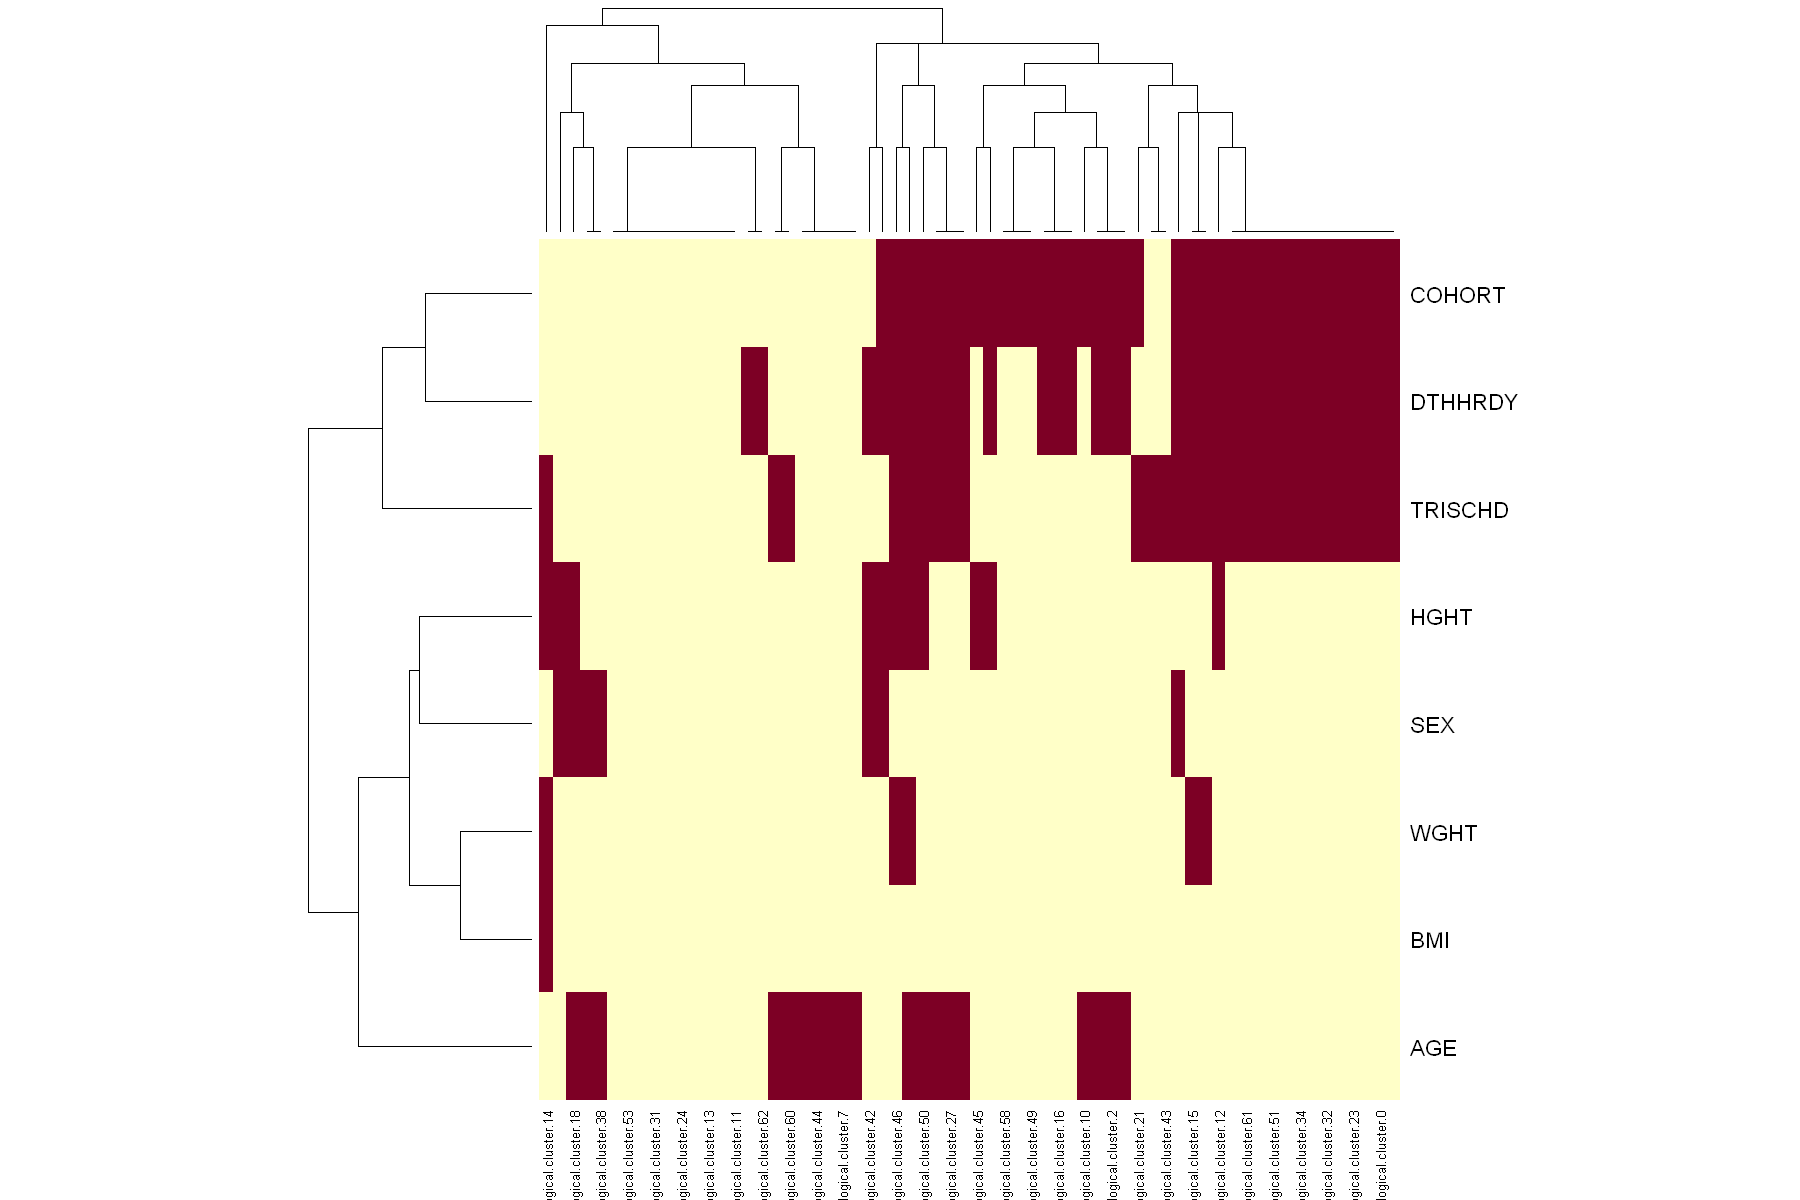

In [52]:
options(repr.plot.width=15, repr.plot.height=10)
heatmap(data.matrix(assoc_table), scale='none')

Controle pour tmps ischémique et cohorte

In [ ]:
dds_ctrl = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~AGE + COHORT)
dds <- DESeq(dds)
res <- results(dds)
resultsNames(dds)
res
summary(res)

In [ ]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)
resSig <- subset(res, padj < 0.05)
resSig[ order(resSig$log2FoldChange), ]
assoc_table[2,] <- colnames(assoc_table) %in% rownames(resSig)
assoc_table

In [ ]:
t(data.matrix(mc)